# Libraries

In [89]:
# Standard Library Imports
import json
import os
from subprocess import check_output
from typing import Any, Optional, Tuple, Union

# Third-Party Library Imports
import albumentations as A
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
# import pytorch_lightning as pl
# from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger
import rasterio as rio
from affine import Affine
from matplotlib.colors import ListedColormap
from os.path import join
from pyproj import Transformer
from rasterio.plot import show_hist
from rasterio.transform import from_origin, rowcol, xy
from shapely.geometry import Polygon
from tqdm.autonotebook import tqdm
from tqdm import tqdm
import torch
import rasterio
from urllib3 import Retry
from pystac_client.stac_api_io import StacApiIO
# import seaborn as sns
import stackstac
import xarray as xr
# from dask_gateway import GatewayCluster
# import xrspatial.multispectral as ms
import planetary_computer
from rasterio.features import rasterize
from shapely.geometry import box
import tempfile

# Third-Party Library Imports (Specific Modules)
from matplotlib import patches as patches
from rasterio.transform import from_origin
from torchvision.models.segmentation import (deeplabv3_resnet50,
                                             DeepLabV3_ResNet50_Weights)
                                            

# Local Project Imports
from rastervision.core.box import Box
from rastervision.core.data import (ClassConfig, GeoJSONVectorSourceConfig, GeoJSONVectorSource,
                                    MinMaxTransformer, MultiRasterSource,
                                    RasterioSource, RasterizedSourceConfig,
                                    RasterizedSource, Scene, StatsTransformer, ClassInferenceTransformer,
                                    VectorSourceConfig, VectorSource, XarraySource)
from rastervision.core.data.raster_source import XarraySource
from rastervision.core.data.raster_transformer import RasterTransformer
from rastervision.core.data.utils import (geoms_to_geojson, geojson_to_geoms,
                                          get_polygons_from_uris)
from rastervision.core.data.vector_source import sanitize_geojson
from rastervision.core.data import (CRSTransformer, IdentityCRSTransformer,
                                    RasterioCRSTransformer)
from rastervision.pipeline.file_system import make_dir
from rastervision.core.raster_stats import RasterStats

from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.pytorch_learner import (SemanticSegmentationGeoDataConfig,
                                          SemanticSegmentationLearner,
                                          SemanticSegmentationLearnerConfig,
                                          SemanticSegmentationRandomWindowGeoDataset,
                                          SemanticSegmentationSlidingWindowGeoDataset,
                                          SemanticSegmentationVisualizer, SolverConfig)
from torch.nn import functional as F
from torchvision.models.segmentation import deeplabv3_resnet50 
from torch.utils.data import DataLoader
from torch.multiprocessing import set_start_method
# from lightning.pytorch import Trainer
from requests.adapters import Retry

# Set torch multiprocessing start method
# set_start_method('fork', force=True)

# Set GDAL_DATA environment variable
os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()

In [90]:
class CustomCRSTransformer(CRSTransformer):
    def __init__(self,
                 transform: Affine,
                 image_crs: Any,
                 map_crs: Any = 'epsg:4326',
                 round_pixels: bool = True):

        if (image_crs is None) or (image_crs == map_crs):
            self.map2image = lambda *args, **kws: args[:2]
            self.image2map = lambda *args, **kws: args[:2]
        else:
            self.map2image = Transformer.from_crs(
                map_crs, image_crs, always_xy=True).transform
            self.image2map = Transformer.from_crs(
                image_crs, map_crs, always_xy=True).transform

        self.round_pixels = round_pixels

        super().__init__(transform, image_crs, map_crs)

    def __repr__(self) -> str:
        cls_name = type(self).__name__

        image_crs_str = str(self.image_crs)
        if len(image_crs_str) > 70:
            image_crs_str = image_crs_str[:70] + '...'

        map_crs_str = str(self.map_crs)
        if len(map_crs_str) > 70:
            map_crs_str = map_crs_str[:70] + '...'

        transform_str = (
            '\n\t\t' + (str(self.transform).replace('\n', '\n\t\t')))
        out = f"""{cls_name}(
            image_crs="{image_crs_str}",
            map_crs="{map_crs_str}",
            round_pixels="{self.round_pixels}",
            transform={transform_str})
        """
        return out

    def _map_to_pixel(self, map_point):
        image_point = self.map2image(*map_point)
        x, y = image_point
        if self.round_pixels:
            row, col = rowcol(self.transform, x, y)
        else:
            row, col = rowcol(self.transform, x, y, op=lambda x: x)
        pixel_point = (col, row)
        return pixel_point

    def _pixel_to_map(self, pixel_point):
        col, row = pixel_point
        if self.round_pixels:
            col = col.astype(int) if isinstance(col, np.ndarray) else int(col)
            row = row.astype(int) if isinstance(row, np.ndarray) else int(row)
        image_point = xy(self.transform, row, col, offset='center')
        map_point = self.image2map(*image_point)
        return map_point
    
    ### ADPATING THIS BIT ###
    @classmethod
    def from_affine_transfrom(
            cls, predefined_transform: Any, map_crs: Optional[str] = 'epsg:4326', image_crs='epsg:4326', **kwargs
    ) -> Union[IdentityCRSTransformer, 'CustomCRSTransformer']:
        transform = predefined_transform
        map_crs = image_crs if map_crs is None else map_crs
        # image_crs = map_crs

        no_crs_tf = (image_crs is None) or (image_crs == map_crs)
        no_affine_tf = (transform is None) or (transform == Affine.identity())
        if no_crs_tf and no_affine_tf:
            return IdentityCRSTransformer()

        if transform is None:
            transform = Affine.identity()

        return cls(transform, image_crs, map_crs, **kwargs)
    
# Helper functions
def plot_geoms(geoms: list, title=''):
    fig, ax = plt.subplots(figsize=(5, 5))
    for g in geoms:
        if g.geom_type == 'Polygon':
            xy = np.array(g.exterior.coords)
            patch = patches.Polygon(xy, color='#55cc77', alpha=0.5)
            ax.add_patch(patch)
            patch = patches.Polygon(xy, edgecolor='#005511', fill=None, alpha=1)
            ax.add_patch(patch)
        elif g.geom_type == 'LineString':
            xy = np.array(g.buffer(1).exterior.coords)
            patch = patches.Polygon(xy, color='#005511', alpha=0.8)
            ax.add_patch(patch)
        else:
            raise NotImplementedError()
    ax.set_title(title, fontsize=14)
    ax.autoscale()
    plt.show()

In [91]:
from typing import TYPE_CHECKING, Any, List, Optional, Sequence, Tuple, Union
import logging

import numpy as np
from xarray import DataArray

from rastervision.core.box import Box
from rastervision.core.data.crs_transformer import RasterioCRSTransformer
from rastervision.core.data.raster_source import RasterSource
from rastervision.core.data.utils import parse_array_slices_Nd, fill_overflow

if TYPE_CHECKING:
    from pystac import Item, ItemCollection
    from rastervision.core.data import RasterTransformer, CRSTransformer

log = logging.getLogger(__name__)

class XarraySource(RasterSource):
    """A RasterSource for reading an Xarry DataArray.

    .. warning:: ``XarraySource`` API is in beta.
    """

    def __init__(self,
                 data_array: DataArray,
                 crs_transformer: 'CRSTransformer',
                 raster_transformers: List['RasterTransformer'] = [],
                 channel_order: Optional[Sequence[int]] = None,
                 bbox: Optional[Box] = None,
                 temporal: bool = False):

        self.temporal = temporal
        if self.temporal:
            if set(data_array.dims) != {'x', 'y', 'band', 'time'}:
                raise ValueError(
                    'If temporal=True, data_array must have 4 dimensions: '
                    '"x", "y", "band", and "time" (in any order).')
        else:
            if set(data_array.dims) != {'x', 'y', 'band'}:
                raise ValueError(
                    'If temporal=False, data_array must have 3 dimensions: '
                    '"x", "y", and "band" (in any order).')

        self.data_array = data_array.transpose(..., 'y', 'x', 'band')
        self.ndim = data_array.ndim
        self._crs_transformer = crs_transformer

        num_channels_raw = len(data_array.band)
        if channel_order is None:
            channel_order = np.arange(num_channels_raw, dtype=int)
        else:
            channel_order = np.array(channel_order, dtype=int)
        self._num_channels = None
        self._dtype = None
        if len(raster_transformers) == 0:
            self._num_channels = len(channel_order)
            self._dtype = data_array.dtype

        height, width = len(data_array.y), len(data_array.x)
        self.full_extent = Box(0, 0, height, width)
        if bbox is None:
            bbox = self.full_extent
        else:
            if bbox not in self.full_extent:
                new_bbox = bbox.intersection(self.full_extent)
                log.warning(f'Clipping ({bbox}) to the DataArray\'s '
                            f'full extent ({self.full_extent}). '
                            f'New bbox={new_bbox}')
                bbox = new_bbox

        super().__init__(
            channel_order,
            num_channels_raw,
            raster_transformers=raster_transformers,
            bbox=bbox)

    @classmethod
    def from_stac(
            cls,
            item_or_item_collection: Union['Item', 'ItemCollection'],
            raster_transformers: List['RasterTransformer'] = [],
            channel_order: Optional[Sequence[int]] = None,
            bbox: Optional[Box] = None,
            bbox_map_coords: Optional[Box] = None,
            temporal: bool = False,
            allow_streaming: bool = False,
            stackstac_args: dict = dict(rescale=False)) -> 'XarraySource':
        """Construct an ``XarraySource`` from a STAC Item or ItemCollection.

        Args:
            item_or_item_collection: STAC Item or ItemCollection.
            raster_transformers: RasterTransformers to use to transform chips
                after they are read.
            channel_order: List of indices of channels to extract from raw
                imagery. Can be a subset of the available channels. If None,
                all channels available in the image will be read.
                Defaults to None.
            bbox: User-specified crop of the extent. If None, the full extent
                available in the source file is used. Mutually exclusive with
                ``bbox_map_coords``. Defaults to ``None``.
            bbox_map_coords: User-specified bbox in EPSG:4326 coords of the
                form (ymin, xmin, ymax, xmax). Useful for cropping the raster
                source so that only part of the raster is read from. Mutually
                exclusive with ``bbox``. Defaults to ``None``.
            temporal: If True, data_array is expected to have a "time"
                dimension and the chips returned will be of shape (T, H, W, C).
            allow_streaming: If False, load the entire DataArray into memory.
                Defaults to True.
            stackstac_args: Optional arguments to pass to stackstac.stack().
        """
        import stackstac

        data_array = stackstac.stack(item_or_item_collection, **stackstac_args)

        if not temporal and 'time' in data_array.dims:
            if len(data_array.time) > 1:
                raise ValueError('temporal=False but len(data_array.time) > 1')
            data_array = data_array.isel(time=0)

        if not allow_streaming:
            from humanize import naturalsize
            log.info('Loading the full DataArray into memory '
                     f'({naturalsize(data_array.nbytes)}).')
            data_array.load()

        crs_transformer = RasterioCRSTransformer(
            transform=data_array.transform, image_crs=data_array.crs)

        if bbox is not None:
            if bbox_map_coords is not None:
                raise ValueError('Specify either bbox or bbox_map_coords, '
                                 'but not both.')
            bbox = Box(*bbox)
        elif bbox_map_coords is not None:
            bbox_map_coords = Box(*bbox_map_coords)
            bbox = crs_transformer.map_to_pixel(bbox_map_coords).normalize()
        else:
            bbox = None

        raster_source = XarraySource(
            data_array,
            crs_transformer=crs_transformer,
            raster_transformers=raster_transformers,
            channel_order=channel_order,
            bbox=bbox,
            temporal=temporal)
        return raster_source

    @property
    def shape(self) -> Tuple[int, int, int]:
        """Shape of the raster as a (height, width, num_channels) tuple."""
        H, W = self.bbox.size
        if self.temporal:
            T = len(self.data_array.time)
            return T, H, W, self.num_channels
        return H, W, self.num_channels

    @property
    def num_channels(self) -> int:

        if self._num_channels is None:
            self._set_info_from_chip()
        return self._num_channels

    @property
    def dtype(self) -> np.dtype:
        if self._dtype is None:
            self._set_info_from_chip()
        return self._dtype

    @property
    def crs_transformer(self) -> RasterioCRSTransformer:
        return self._crs_transformer

    def _set_info_from_chip(self):
        """Read 1x1 chip to get info not statically inferable."""
        test_chip = self.get_chip(Box(0, 0, 1, 1))
        self._dtype = test_chip.dtype
        self._num_channels = test_chip.shape[-1]

    def _get_chip(self,
                  window: Box,
                  bands: Union[int, Sequence[int], slice] = slice(None),
                  time: Union[int, Sequence[int], slice] = slice(None),
                  out_shape: Optional[Tuple[int, ...]] = None) -> np.ndarray:
        window = window.to_global_coords(self.bbox)

        window_within_bbox = window.intersection(self.bbox)

        yslice, xslice = window_within_bbox.to_slices()
        if self.temporal:
            chip = self.data_array.isel(
                x=xslice, y=yslice, band=bands, time=time).to_numpy()
        else:
            chip = self.data_array.isel(
                x=xslice, y=yslice, band=bands).to_numpy()

        if window != window_within_bbox:
            *batch_dims, h, w, c = chip.shape
            # coords of window_within_bbox within window
            yslice, xslice = window_within_bbox.to_local_coords(
                window).to_slices()
            tmp = np.zeros((*batch_dims, *window.size, c))
            tmp[..., yslice, xslice, :] = chip
            chip = tmp

        chip = fill_overflow(self.bbox, window, chip)
        if out_shape is not None:
            chip = self.resize(chip, out_shape)
        return chip

    def get_chip(self,
                 window: Box,
                 bands: Optional[Union[int, Sequence[int], slice]] = None,
                 time: Union[int, Sequence[int], slice] = slice(None),
                 out_shape: Optional[Tuple[int, ...]] = None) -> np.ndarray:
        """Read a chip specified by a window from the file.

        Args:
            window (Box): Bounding box of chip in pixel coordinates.
            bands (Optional[Union[Sequence[int], slice]], optional): Subset of
                bands to read. Note that this will be applied on top of the
                channel_order (if specified). So if this is an RGB image and
                channel_order=[2, 1, 0], then using bands=[0] will return the
                B-channel. Defaults to None.
            out_shape (Optional[Tuple[int, ...]], optional): (height, width) of
                the output chip. If None, no resizing is done.
                Defaults to None.

        Returns:
            np.ndarray: A chip of shape (height, width, channels).
        """
        if bands is None or bands == slice(None):
            bands = self.channel_order
        else:
            bands = self.channel_order[bands]
        chip = self._get_chip(
            window, bands=bands, time=time, out_shape=out_shape)
        for transformer in self.raster_transformers:
            chip = transformer.transform(chip, bands)
        return chip

    def __getitem__(self, key: Any) -> 'np.ndarray':
        if isinstance(key, Box):
            return self.get_chip(key)

        window, dim_slices = parse_array_slices_Nd(
            key, extent=self.extent, dims=self.ndim)
        if self.temporal:
            t, h, w, c = dim_slices
        else:
            h, w, c = dim_slices
            t = None

        out_shape = None
        if h.step is not None or w.step is not None:
            out_h, out_w = window.size
            if h.step is not None:
                out_h //= h.step
            if w.step is not None:
                out_w //= w.step
            out_shape = (int(out_h), int(out_w))

        chip = self.get_chip(window, bands=c, time=t, out_shape=out_shape)
        return chip
    
    def calculate_ndbi(chip, nir_band=3, swir_band=4):
        nir = chip[:, :, nir_band]  # NIR band
        swir = chip[:, :, swir_band]  # SWIR band
        ndbi = (swir - nir) / (swir + nir)

        return ndbi
    
    def patched_get_chip(self, window: Box, bands=None, time=slice(None), out_shape=None):
        chip = self._get_chip(window, bands=bands, time=time, out_shape=out_shape)

        # Compute NDBI if NIR and SWIR bands are present
        if 3 in bands and 4 in bands:  # Assuming NIR is at index 3 and SWIR is at index 4
            ndbi = calculate_ndbi(chip)
            # Add NDBI as the fifth channel
            ndbi = np.expand_dims(ndbi, axis=2)
            chip_with_ndbi = np.concatenate((chip, ndbi), axis=2)
            return chip_with_ndbi

        return chip

In [92]:
class CustomMinMaxTransformer(RasterTransformer):
    """Transforms chips by scaling values in each channel to span a specified range."""

    def __init__(self, min_val: Union[float, List[float]], max_val: Union[float, List[float]]):
        """
        Args:
            min_val: Minimum value(s) for scaling. If a single value is provided, it will be broadcasted
                across all channels. If a list of values is provided, it should match the number of channels.
            max_val: Maximum value(s) for scaling. Same broadcasting rules as min_val apply.
        """
        self.min_val = min_val
        self.max_val = max_val

    def transform(self,
                  chip: np.ndarray,
                  channel_order: Optional[List[int]] = None) -> np.ndarray:
        c = chip.shape[-1]
        pixels = chip.reshape(-1, c)
        
        # Broadcasting if single value provided
        if isinstance(self.min_val, (int, float)):
            channel_mins = np.array([self.min_val] * c)
        else:
            channel_mins = np.array(self.min_val)
        
        if isinstance(self.max_val, (int, float)):
            channel_maxs = np.array([self.max_val] * c)
        else:
            channel_maxs = np.array(self.max_val)
        
        chip_normalized = (chip - channel_mins) / (channel_maxs - channel_mins)
        chip_normalized = np.clip(chip_normalized, 0, 1)  # Clip values to [0, 1] range
        chip_normalized = (255 * chip_normalized).astype(np.uint8)
        return chip_normalized

In [93]:
# Rasterisation adapted to change dtype
def customgeoms_to_raster(df: gpd.GeoDataFrame, window: 'Box',
                    background_class_id: int, all_touched: bool) -> np.ndarray:
    if len(df) == 0:
        return np.full(window.size, background_class_id, dtype=np.uint8)

    window_geom = window.to_shapely()

    # subset to shapes that intersect window
    df_int = df[df.intersects(window_geom)]
    # transform to window frame of reference
    shapes = df_int.translate(xoff=-window.xmin, yoff=-window.ymin)
    # class IDs of each shape
    class_ids = df_int['class_id']

    if len(shapes) > 0:
        raster = rasterize(
            shapes=list(zip(shapes, class_ids)),
            out_shape=window.size,
            fill=background_class_id,
            dtype='uint8',
            all_touched=all_touched)
    else:
        raster = np.full(window.size, background_class_id, dtype=np.uint8)

    return raster


class CustomRasterizedSource(RasterSource):
    def __init__(self,
                 vector_source: 'VectorSource',
                 background_class_id: int,
                 bbox: Optional['Box'] = None,
                 all_touched: bool = False,
                 raster_transformers: List['RasterTransformer'] = []):
        self.vector_source = vector_source
        self.background_class_id = background_class_id
        self.all_touched = all_touched

        self.df = self.vector_source.get_dataframe()
        self.validate_labels(self.df)

        if bbox is None:
            bbox = self.vector_source.extent

        super().__init__(
            channel_order=[0],
            num_channels_raw=1,
            bbox=bbox,
            raster_transformers=raster_transformers)

    @property
    def dtype(self) -> np.dtype:
        return np.uint8

    @property
    def crs_transformer(self):
        return self.vector_source.crs_transformer

    def _get_chip(self,
                  window: 'Box',
                  out_shape: Optional[Tuple[int, int]] = None) -> np.ndarray:
        window = window.to_global_coords(self.bbox)
        chip = customgeoms_to_raster(
            self.df,
            window,
            background_class_id=self.background_class_id,
            all_touched=self.all_touched)

        if out_shape is not None:
            chip = self.resize(chip, out_shape)

        # Add third singleton dim since rasters must have >=1 channel.
        return np.expand_dims(chip, 2)

    def validate_labels(self, df: gpd.GeoDataFrame) -> None:
        geom_types = set(df.geom_type)
        if 'Point' in geom_types or 'LineString' in geom_types:
            raise ValueError('LineStrings and Points are not supported '
                             'in RasterizedSource. Use BufferTransformer '
                             'to buffer them into Polygons. '
                             f'Geom types found in data: {geom_types}')

        if len(df) > 0 and 'class_id' not in df.columns:
            raise ValueError('All label polygons must have a class_id.')

In [94]:
class KnownStatsTransformer(RasterTransformer):
    def __init__(self,
                 means: Sequence[float],
                 stds: Sequence[float],
                 max_stds: float = 3.):
        # shape = (1, 1, num_channels)
        self.means = np.array(means, dtype=float)
        self.stds = np.array(stds, dtype=float)
        self.max_stds = max_stds

    def transform(self,
                  chip: np.ndarray,
                  channel_order: Optional[Sequence[int]] = None) -> np.ndarray:
        if chip.dtype == np.uint8:
            return chip

        means = self.means
        stds = self.stds
        max_stds = self.max_stds
        if channel_order is not None:
            means = means[channel_order]
            stds = stds[channel_order]

        # Don't transform NODATA zero values.
        nodata_mask = chip == 0

        # Subtract mean and divide by std to get zscores.
        chip = chip.astype(float)
        for i in range(chip.shape[-1]):  # Loop over channels
            chip[..., i] -= means[i]
            chip[..., i] /= stds[i]

        chip[nodata_mask] = 0

        # Normalize to have standard deviation of 1 if desired
        for i in range(chip.shape[-1]):
            chip[..., i] /= np.std(chip[..., i])

        return chip

In [95]:
class CustomStatsTransformer(RasterTransformer):
    def __init__(self,
                 means: Sequence[float],
                 stds: Sequence[float],
                 max_stds: float = 3.):
   
        # shape = (1, 1, num_channels)
        self.means = np.array(means, dtype=float)
        self.stds = np.array(stds, dtype=float)
        self.max_stds = max_stds

    def transform(self,
                  chip: np.ndarray,
                  channel_order: Optional[Sequence[int]] = None) -> np.ndarray:
        if chip.dtype == np.uint8:
            return chip

        means = self.means
        stds = self.stds
        max_stds = self.max_stds
        if channel_order is not None:
            means = means[channel_order]
            stds = stds[channel_order]

        # Don't transform NODATA zero values.
        nodata_mask = chip == 0

        # Subtract mean and divide by std to get zscores.
        chip = chip.astype(float)
        for i in range(chip.shape[-1]):  # Loop over channels
            chip[..., i] -= means[i]
            chip[..., i] /= stds[i]

        chip[nodata_mask] = 0

        # Normalize to have standard deviation of 1 if desired
        for i in range(chip.shape[-1]):
            chip[..., i] /= np.std(chip[..., i])

        return chip

    @classmethod
    def from_raster_sources(cls,
                            raster_sources: List['RasterSource'],
                            sample_prob: Optional[float] = 0.1,
                            max_stds: float = 3.,
                            chip_sz: int = 300) -> 'StatsTransformer':
       
        stats = RasterStats()
        stats.compute(
            raster_sources=raster_sources,
            sample_prob=sample_prob,
            chip_sz=chip_sz)
        stats_transformer = StatsTransformer.from_raster_stats(
            stats, max_stds=max_stds)
        return stats_transformer
    
    @classmethod
    def from_raster_stats(cls, stats: RasterStats,
                          max_stds: float = 3.) -> 'CustomStatsTransformer':
        stats_transformer = cls(stats.means, stats.stds, max_stds=max_stds)
        return stats_transformer

# Vector Source

In [77]:
# Manually define the affine transformation matrix
label_uri = '../data/0/overture/santodomingo_buildings.parquet'
gdf = gpd.read_parquet(label_uri)
print(gdf.crs)
xmin, ymin, xmax, ymax = gdf.total_bounds
scale_factor = 0.000009462403025800147 #  roughly 1 metre for lat 18
translate_x = xmin  
translate_y = ymin 
affine_transform = Affine(scale_factor, 0, translate_x,
                          0, -scale_factor, translate_y)
print("Created affine transform: ", affine_transform)

{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope": "Horizontal component of 3D system.", "area": "World.", "bb

In [78]:
label_uri = '../data/0/overture/santodomingo_buildings.geojson'

crs_transformer = CustomCRSTransformer.from_affine_transfrom(
    affine_transform, map_crs='epsg:4326',
    image_crs='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

vector_source = GeoJSONVectorSource(
    label_uri,
    crs_transformer,
    vector_transformers=[ClassInferenceTransformer(default_class_id=1)])

rasterized_source = CustomRasterizedSource(
    vector_source,
    background_class_id=0)

Simplifying polygons:  31%|███       | 98248/320295 [00:05<00:13, 17074.51it/s]


KeyboardInterrupt: 

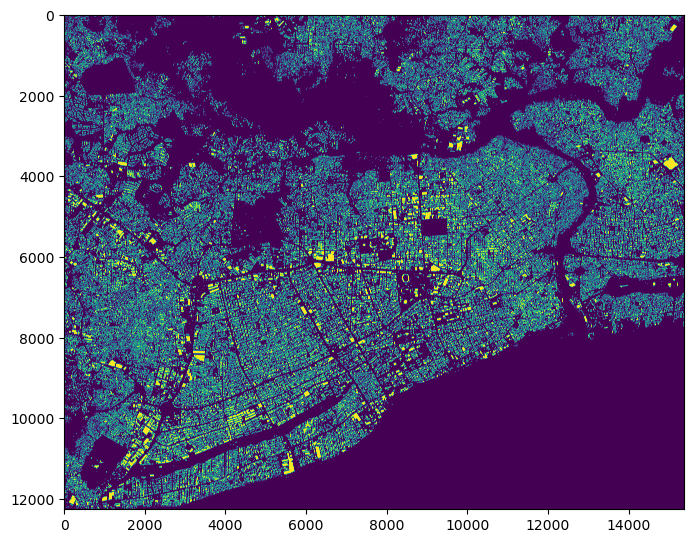

In [ ]:
chip = rasterized_source[:, :, :]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(chip)
plt.show()

# Reading Labels

In [ ]:
SD_infset = gpd.read_file('../data/0/UNITAC_data/SantoDomingo_PS_modified.geojson')
SD_infset = SD_infset.to_crs('EPSG:4326')

SD_infset = SD_infset.unary_union
SD_infset = SD_infset.simplify(tolerance=0.0001, preserve_topology=True)
SD_infset_gs = gpd.GeoSeries([SD_infset])
# SD_infset_gs.to_file('../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson', driver='GeoJSON')

gdf = gpd.read_file("../data/1/UNITAC_data/SantoDomingo_PS.geojson")
gdf = gdf.to_crs('EPSG:3857')

xmin, ymin, xmax, ymax = gdf.total_bounds
scale_factor = 10 #0.000009462403025800147 #  roughly 1 metre for lat 18
translate_x = xmin  
translate_y = ymin
affine_transform_labels = Affine(scale_factor, 0, translate_x,
                          0, -scale_factor, translate_y)
print("Created affine transform: ", affine_transform_labels)

Created affine transform:  | 10.00, 0.00,-7792239.92|
| 0.00,-10.00, 2087517.56|
| 0.00, 0.00, 1.00|


In [ ]:
img_uri = '../data/1/UNITAC_data/SantoDomingo_PS.tif'
label_uri = '../data/1/UNITAC_data/SantoDomingo_PS.geojson'

crs_transformer_11 = RasterioCRSTransformer.from_uri(img_uri)
crs_transformer_11

RasterioCRSTransformer(
            image_crs="GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER...",
            map_crs="epsg:4326",
            round_pixels="True",
            transform=
		| 0.00, 0.00,-70.00|
		| 0.00,-0.00, 18.54|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
crs_transformer_labels = CustomCRSTransformer.from_affine_transfrom(
    affine_transform_labels, map_crs='epsg:3857',
    image_crs='GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,3],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],AXIS["ellipsoidal height (h)",up,ORDER[3],LENGTHUNIT["metre",1]],USAGE[SCOPE["Geodesy. Navigation and positioning using GPS satellite system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4979]]')

crs_transformer_labels

CustomCRSTransformer(
            image_crs="GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER...",
            map_crs="epsg:3857",
            round_pixels="True",
            transform=
		| 10.00, 0.00,-7792239.92|
		| 0.00,-10.00, 2087517.56|
		| 0.00, 0.00, 1.00|)
        

In [ ]:
class_config = ClassConfig(names=['background', 'slums'], 
                           colors=['lightgray', 'darkred'],
                           null_class='background')

label_vector_source = GeoJSONVectorSource(
    '../data/1/UNITAC_data/SantoDomingo_PS_modified.geojson',
    crs_transformer_labels,
    vector_transformers=[
        ClassInferenceTransformer(
            default_class_id=class_config.get_class_id('slums'))])

label_raster_source = RasterizedSource(
    label_vector_source,
    background_class_id=class_config.null_class_id)

AttributeError: 'NoneType' object has no attribute 'envelope'

In [ ]:
from rastervision.core.data import SemanticSegmentationLabelSource

label_source = SemanticSegmentationLabelSource(
    label_raster_source, class_config=class_config)

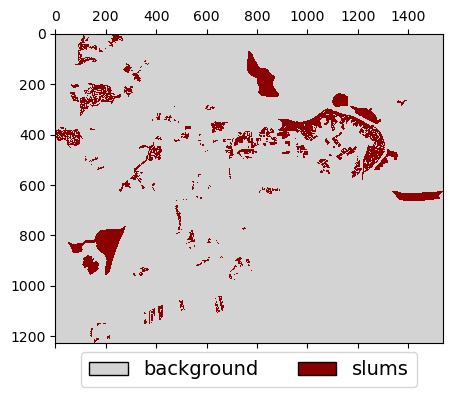

In [ ]:
label_chip = label_source[:, :]

fig, ax = plt.subplots(figsize=(5, 5))
cmap = ListedColormap(class_config.color_triples)
ax.matshow(label_chip, cmap=cmap)

legend_items = [
    patches.Patch(facecolor=cmap(i), edgecolor='black', label=cname)
    for i, cname in enumerate(class_config.names)]
ax.legend(
    handles=legend_items,
    ncol=len(class_config),
    loc='upper center',
    fontsize=14,
    bbox_to_anchor=(0.5, 0))
plt.show()

# Raster Source

## Sentinel

In [96]:
# ### SENTINEL source directly from Earth Search
# bounds = gdf.total_bounds
# geom = Polygon([
#     (bounds[0], bounds[1]),
#     (bounds[2], bounds[1]),
#     (bounds[2], bounds[3]),
#     (bounds[0], bounds[3]),
#     (bounds[0], bounds[1])
# ])
# shape = box(*bounds)
# bbox = Box.from_shapely(shape)

In [ ]:
# temp small polygon for testing
BANDS = [
    'coastal', # B01
    'blue', # B02
    'green', # B03
    'red', # B04
    'rededge1', # B05
    'rededge2', # B06
    'rededge3', # B07
    'nir', # B08
    'nir08', # B8A
    'nir09', # B09
    'swir16', # B11
    'swir22', # B12
]

coords = [[[-69.9024900567,18.4849422484],[-69.8642302632,18.4849422484],[-69.8642302632,18.5181103546],[-69.9024900567,18.5181103546],[-69.9024900567,18.4849422484]]]
bbox_coords = coords[0]
geom = Polygon(bbox_coords)

xmin = min(coord[0] for coord in bbox_coords)
ymin = min(coord[1] for coord in bbox_coords)
xmax = max(coord[0] for coord in bbox_coords)
ymax = max(coord[1] for coord in bbox_coords)

# Instantiate the Box class
bbox = Box(ymin, xmin, ymax, xmax)
bounds = gdf.total_bounds

In [ ]:
# # import dask_gateway
# from dask.distributed import LocalCluster
# cluster = LocalCluster()
# client = cluster.get_client()
# cluster.adapt(minimum=2, maximum=18)
# print(cluster.dashboard_link)

In [ ]:
# # cluster.scale(4)
# cluster.close()

In [ ]:
from rasterio import RasterioIOError
retry = Retry(total=5, backoff_factor=1, status_forcelist=[502, 503, 504], allowed_methods=["HEAD", "GET", "OPTIONS"])
stac_api_io = StacApiIO(max_retries=retry)

# stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",stac_io=stac_api_io,
#     modifier=planetary_computer.sign_inplace 
# ) # sentinel-2-l2a

stac = pystac_client.Client.open('https://earth-search.aws.element84.com/v1',stac_io=stac_api_io) # sentinel-2-c1-l2a

items = stac.search(
    # intersects=geom,
    bbox = tuple(bbox),
    collections=['sentinel-2-c1-l2a'],
    datetime='2024-01-01/2024-05-17',
    query={'eo:cloud_cover': {'lt': 25}},
).item_collection()
print(f"Number of items found: {len(items)}")

data = (
    stackstac.stack(
        items,
        # assets=["B04", "B03", "B02", "B08"],  # red, green, blue
        chunksize=1024,
        resolution=10,
        epsg=3857,
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)

Number of items found: 5


In [27]:
# data_array = stackstac.stack(items, assets=BANDS, rescale=False, fill_value=0, bounds_latlon=bounds, epsg=3857, resolution=10)
datamosaicked = stackstac.mosaic(data, dim="time", nodata=0, reverse=False).squeeze()

In [29]:
crs_transformer_sentinel = RasterioCRSTransformer(transform=datamosaicked.transform, image_crs=datamosaicked.crs)
# #'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')
print(datamosaicked.shape)

(19, 34487, 41350)


In [24]:
# crs_transformer_temp = RasterioCRSTransformer(transform=data_array.transform, image_crs=data_array.crs)
# bbox_map_coords = tuple(bbox)
# bbox_map_coords = Box(*bbox_map_coords)
# bbox_transformed = crs_transformer_temp.map_to_pixel(bbox_map_coords).normalize()

In [30]:
raster_source_unnormalized = XarraySource(
    datamosaicked,
    temporal=False,
    crs_transformer=crs_transformer_sentinel,
    # bbox = Box(0, 0, 500, 500),#bbox_transformed,
    channel_order = [1,2,3,7] # R,G,B + NDBI; 7,10 = NIR, SWIR,
)
stats_tf = StatsTransformer.from_raster_sources([raster_source_unnormalized], chip_sz=100)

Analyzing chips: 0it [00:02, ?it/s]


RuntimeError: Assets must have exactly 1 band, but file 'https://e84-earth-search-sentinel-data.s3.us-west-2.amazonaws.com/sentinel-2-c1-l2a/33/D/XC/2024/1/S2B_T33DXC_20240106T073941_L2A/TCI.tif' has 3. We can't currently handle multi-band rasters (each band has to be a separate STAC asset), so you'll need to exclude this asset from your analysis.

In [1]:
# sentinel_source_final = XarraySource(
#     median,
#     # temporal=True,
#     raster_transformers=[stats_tf],
#     crs_transformer=crs_transformer_sentinel,
#     bbox = Box(0, 0, 500, 500),# bbox_transformed,
#     channel_order = [3,2,1,7] # R,G,B + NIR + SWIR
# )
# print(sentinel_source_final.shape)

# chip = sentinel_source_final[:, :, [0,1,2]]# [:400:4, :400:4, [0]]
# chip.shape

# fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# ax.imshow(chip)
# plt.show()

In [ ]:
chip_normalized = sentinel_source_final[:400, :400]
band_colors = ['r', 'g', 'b', 'y', 'black']  # Define colors for each band
chip_unnormalized = raster_source_unnormalized[:400, :400]

fig, (ax_l, ax_r) = plt.subplots(1, 2, squeeze=True, figsize=(12, 6))

# left
for i in range(chip_unnormalized.shape[-1]):
    sns.kdeplot(chip_unnormalized[..., i].flat, ax=ax_l, color=band_colors[i], label=f'Band {i+1}')
ax_l.set_xscale('log')
ax_l.set_xlabel('Pixel values')
ax_l.legend()
ax_l.set_title('Without StatsTransformer')

# right
for i in range(chip_normalized.shape[-1]):
    sns.kdeplot(chip_normalized[..., i].flat, ax=ax_r, color=band_colors[i], label=f'Band {i+1}')
ax_r.set_xlabel('Pixel values')
ax_r.legend()
ax_r.set_title('With StatsTransformer')

plt.show()

## DEM data

In [ ]:
# dem_uri = '../data/0/SD-DEM.tif'
# with rasterio.open(dem_uri) as src:
#     dem_data = src.read(1)

# filtered_dem_data = np.where((dem_data >= -10) & (dem_data <= 50), dem_data, np.nan)
# plt.figure(figsize=(10, 5))
# show_hist(filtered_dem_data, bins=70, title='Histogram of Filtered DEM Raster Values')
# plt.show()

In [ ]:
# SD_dem = rd.LoadGDAL(dem_uri)

# #save slope GeoTif
# slope = rd.TerrainAttribute(SD_dem, attrib='slope_riserun')
# rd.SaveGDAL('../data/0/SD-DEM_slope.tif', slope)

# # show slope
# rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
# plt.show()

In [ ]:
# slope_uri = ['../data/0/SD-DEM_slope.tif']

# slope_source = RasterioSource(slope_uri, allow_streaming=True)#, raster_transformers=[MinMaxTransformer()])

# slope_stats_transformer = StatsTransformer.from_raster_sources(
#     raster_sources=[slope_source],
#     max_stds=3)

# slope_source_normalized = RasterioSource(
#     slope_uri,
#     allow_streaming=True,
#     raster_transformers=[slope_stats_transformer])
    

# print(slope_source_normalized.shape)
# print(slope_source_normalized.dtype)

# chip = slope_source_normalized[:898, :2054]

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.matshow(chip)
# plt.show()

## Planet Imagery source

In [117]:
class CustomStatsTransformer(RasterTransformer):
    def __init__(self,
                 means: Sequence[float],
                 stds: Sequence[float],
                 max_stds: float = 3.):
        # shape = (1, 1, num_channels)
        self.means = np.array(means, dtype=float)
        self.stds = np.array(stds, dtype=float)
        self.max_stds = max_stds

    def transform(self,
                  chip: np.ndarray,
                  channel_order: Optional[Sequence[int]] = None) -> np.ndarray:
        if chip.dtype == np.uint8:
            return chip

        means = self.means
        stds = self.stds
        max_stds = self.max_stds
        if channel_order is not None:
            means = means[channel_order]
            stds = stds[channel_order]

        # Don't transform NODATA zero values.
        nodata_mask = chip == 0

        # Convert chip to float (if not already)
        chip = chip.astype(float)

        # Subtract mean and divide by std to get z-scores.
        for i in range(chip.shape[-1]):  # Loop over channels
            chip[..., i] -= means[i]
            chip[..., i] /= stds[i]

        # Apply max_stds clipping
        chip = np.clip(chip, -max_stds, max_stds)
        chip = (chip - chip.min()) / (chip.max() - chip.min())
    
        # # Normalize to have standard deviation of 1 if desired
        # for i in range(chip.shape[-1]):
        #     chip[..., i] /= np.std(chip[..., i])

        chip[nodata_mask] = 0

        return chip

    @classmethod
    def from_raster_sources(cls,
                            raster_sources: List['RasterSource'],
                            sample_prob: Optional[float] = 0.1,
                            max_stds: float = 3.,
                            chip_sz: int = 300) -> 'CustomStatsTransformer':
        stats = RasterStats()
        stats.compute(
            raster_sources=raster_sources,
            sample_prob=sample_prob,
            chip_sz=chip_sz)
        stats_transformer = cls.from_raster_stats(
            stats, max_stds=max_stds)
        return stats_transformer
    
    @classmethod
    def from_raster_stats(cls, stats: RasterStats,
                          max_stds: float = 3.) -> 'CustomStatsTransformer':
        stats_transformer = cls(stats.means, stats.stds, max_stds=max_stds)
        return stats_transformer

In [118]:
image_uri = ['../data/0/sentinel_Gee/GTM_Santa_Lucia_Cotzumalguapa_2023.tif']

# Define an unnormalized raster source
sentinel_source_unnormalized = RasterioSource(
    image_uri,
    allow_streaming=True)

# Calculate statistics transformer from the unnormalized source
calc_stats_transformer = CustomStatsTransformer.from_raster_sources(
    raster_sources=[sentinel_source_unnormalized],
    max_stds=3
)

# Define a normalized raster source using the calculated transformer
sentinel_source_normalized = RasterioSource(
    image_uri,
    allow_streaming=True,
    raster_transformers=[calc_stats_transformer],
    channel_order=[2, 1, 0, 3],
)

Analyzing chips: 2it [00:00, 30.24it/s]


Minimum pixel value after normalization: 0.0
Maximum pixel value after normalization: 1.0


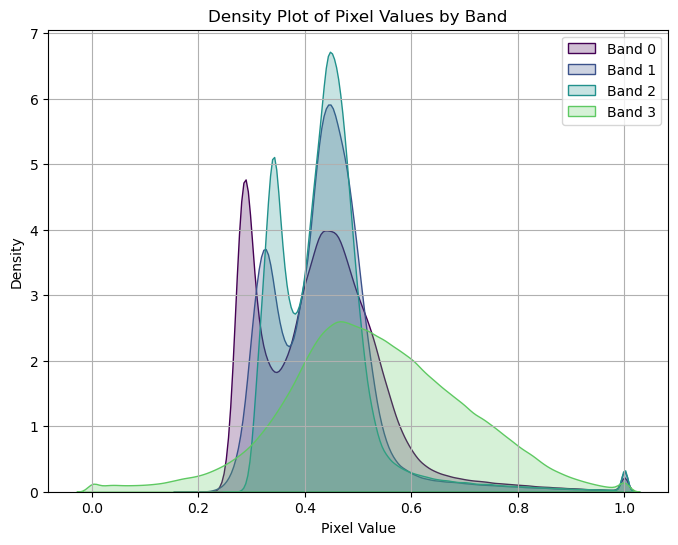

In [120]:
# After normalization with CustomStatsTransformer
chip_calc = sentinel_source_normalized[:, :, :]  # Adjust based on your RasterSource implementation

# Check minimum and maximum values after normalization
print(f"Minimum pixel value after normalization: {chip_calc.min()}")
print(f"Maximum pixel value after normalization: {chip_calc.max()}")

# Extract number of bands (channels)
num_bands = chip_calc.shape[-1]

# Plot density plot for each band with different colors
plt.figure(figsize=(8, 6))
for band in range(num_bands):
    band_data = chip_calc[..., band].flatten()
    sns.kdeplot(band_data, shade=True, label=f'Band {band}', color=plt.cm.viridis(band / num_bands))

plt.title('Density Plot of Pixel Values by Band')
plt.xlabel('Pixel Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


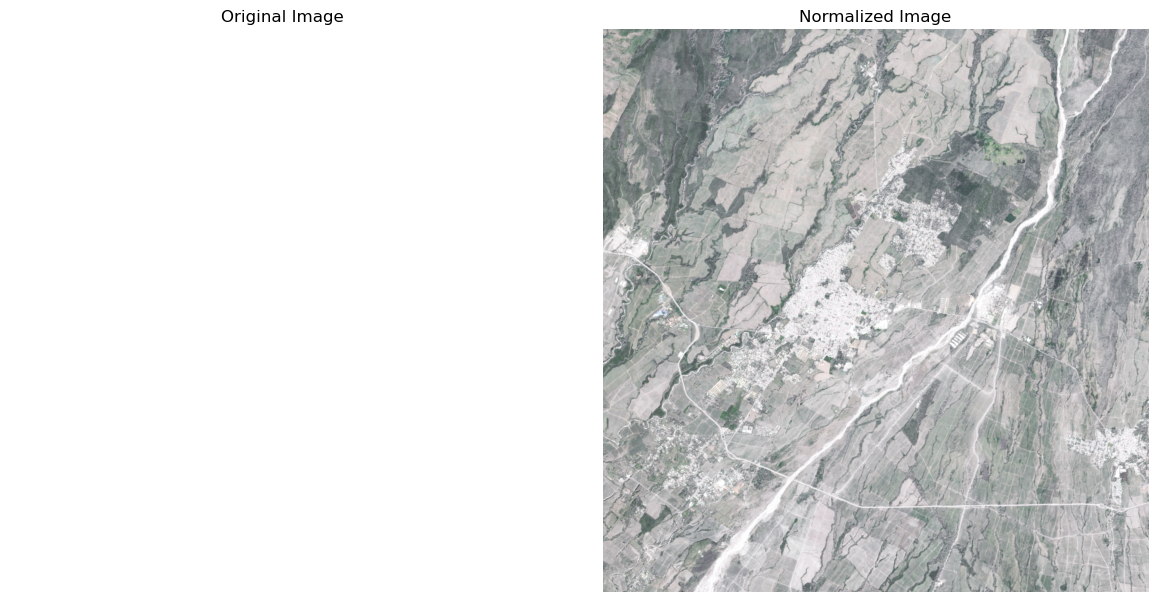

In [121]:
# Fetch the original and normalized images
original_image = sentinel_source_unnormalized[:, :, :]
normalized_image = sentinel_source_normalized[:, :, :]

# Plot the original and normalized images
plt.figure(figsize=(12, 6))

# Plot original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Plot normalized image
plt.subplot(1, 2, 2)
plt.imshow(normalized_image)
plt.title('Normalized Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [65]:
from rastervision.core.data import RasterioSource

image_uri = ['../data/0/sentinel_Gee/GTM_Santa_Lucia_Cotzumalguapa_2023.tif']

predefined_stats_transformer = KnownStatsTransformer(means = [2581.270, 1298.905, 1144.928, 934.346], stds=[586.279, 458.048, 302.029, 244.423])

sentinel_source_unnormalized = RasterioSource(
    image_uri,
    allow_streaming=True)
    # channel_order=[2,1,0,3])

calc_stats_transformer = CustomStatsTransformer.from_raster_sources(
    raster_sources=[sentinel_source_unnormalized],
    max_stds=3)

Analyzing chips: 0it [00:00, ?it/s]

Analyzing chips: 2it [00:00, 35.26it/s]


In [59]:
sentinel_source_normalized_known = RasterioSource(
    image_uri,
    allow_streaming=True,
    raster_transformers=[predefined_stats_transformer],
    channel_order=[2,1,0,3])

sentinel_source_normalized_calc = RasterioSource(
    image_uri,
    allow_streaming=True,
    raster_transformers=[calc_stats_transformer],
    channel_order=[2,1,0,3])

print(sentinel_source_normalized_known.dtype)
print(sentinel_source_normalized_calc.dtype)

float64
uint8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


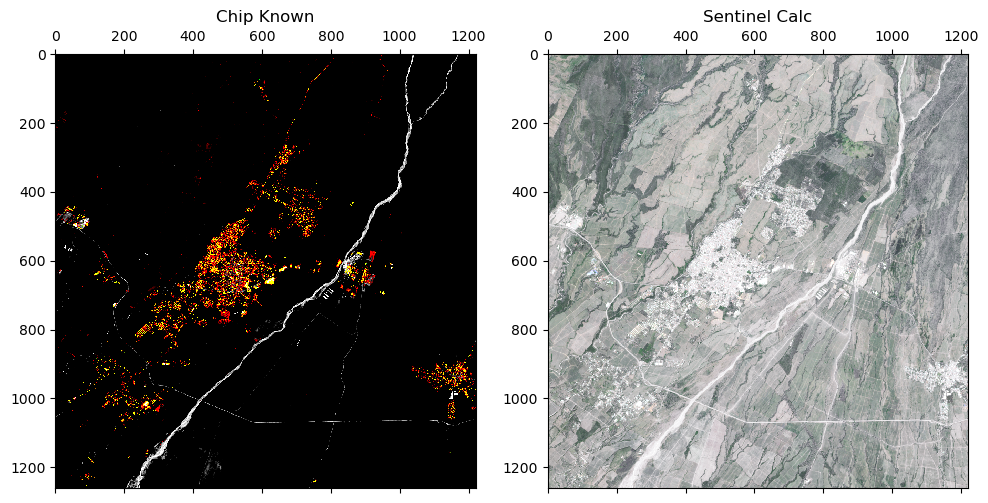

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

# Plotting chip_normalized in the first subplot
chip_normalized_known = sentinel_source_normalized_known[:, :]
axs[0].matshow(chip_normalized_known)
axs[0].set_title('Chip Known')

# Plotting sentinel_source_normalized_calc in the second subplot
chip_normalized_calc = sentinel_source_normalized_calc[:, :]
axs[1].matshow(chip_normalized_calc)
axs[1].set_title('Sentinel Calc')

plt.tight_layout()
plt.show()

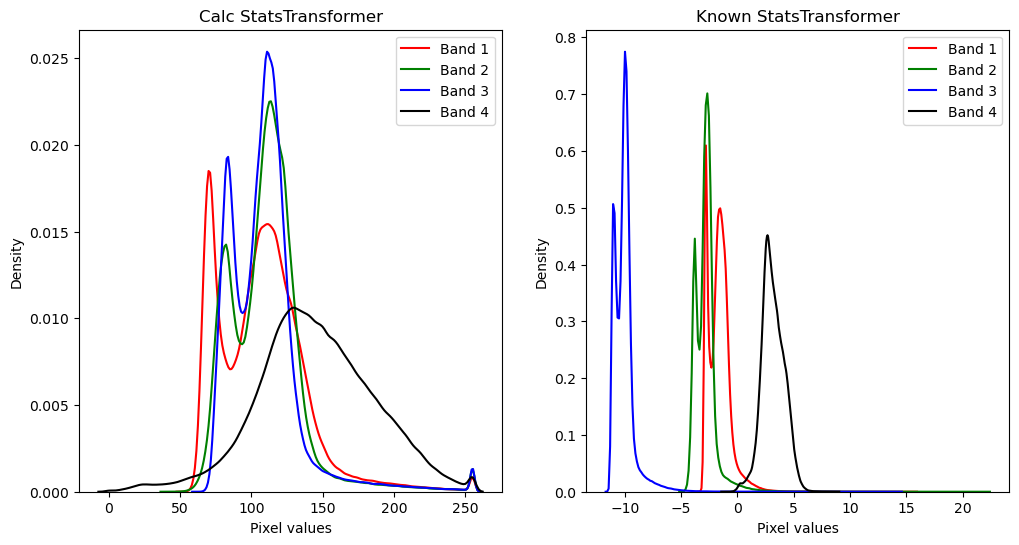

In [63]:
import seaborn as sns
chip_known = sentinel_source_normalized_known[:1000, :1000]
band_colors = ['r', 'g', 'b', 'black']  # Define colors for each band
chip_calc = sentinel_source_normalized_calc[:, :, :]

fig, (ax_l, ax_r) = plt.subplots(1, 2, squeeze=True, figsize=(12, 6))

# left
for i in range(chip_calc.shape[-1]):
    sns.kdeplot(chip_calc[..., i].flat, ax=ax_l, color=band_colors[i], label=f'Band {i+1}')
# ax_l.set_xscale('log')
ax_l.set_xlabel('Pixel values')
ax_l.legend()
ax_l.set_title('Calc StatsTransformer')

# right
for i in range(chip_known.shape[-1]):
    sns.kdeplot(chip_known[..., i].flat, ax=ax_r, color=band_colors[i], label=f'Band {i+1}')
ax_r.set_xlabel('Pixel values')
ax_r.legend()
ax_r.set_title('Known StatsTransformer')

plt.show()

# MultiRaster source

In [ ]:
raster_source_multi = MultiRasterSource(
    raster_sources=[rasterized_source, sentinel_source_final], primary_source_idx=0,
    force_same_dtype = True
    ) #planet_source, slope_source_normalized
print(f"Buildings raster: {rasterized_source.shape, rasterized_source.dtype}")
print(f"Sentinel raster: {sentinel_source_final.shape, sentinel_source_final.dtype}")
print(f"Final multiraster: {raster_source_multi.shape, raster_source_multi.dtype}")

In [ ]:
chip = raster_source_multi[:, :]

In [ ]:
fig, (ax_buil, ax_rgb, ax_nir, ax_swir) = plt.subplots(1, 4, figsize=(15, 3))

ax_buil.matshow(chip[..., 0])
ax_buil.set_title('Buildings')

ax_rgb.matshow(chip[..., 1:4])
ax_rgb.set_title('RGB')

ax_nir.matshow(chip[..., 4])
ax_nir.set_title('NIR')

ax_swir.matshow(chip[..., 5])
ax_swir.set_title('SWIR')

plt.show()

In [ ]:
def show_windows(img, windows, title=''):
    from matplotlib import pyplot as plt
    import matplotlib.patches as patches

    fig, ax = plt.subplots(1, 1, squeeze=True, figsize=(8, 8))
    ax.imshow(img)
    ax.axis('off')
    for w in windows:
        p = patches.Polygon(w.to_points(), color='r', linewidth=1, fill=False)
        ax.add_patch(p)
    ax.autoscale()
    ax.set_title(title)
    plt.show()
    
img_full = ds.scene.raster_source[:, :]

show_windows(img_full, ds.windows, title='Sliding windows')

# Scene

In [ ]:
aoi_polygon = Polygon.from_bounds(xmin=0, ymin=0, xmax=155372, ymax=11712)

SD_scene = Scene(
    id='santo_domingo',
    raster_source=raster_source_multi,
    label_source=label_source)
    # aoi_polygons=[aoi_polygon])

data_augmentation_transform = A.Compose([A.Flip(), A.ShiftScaleRotate()])

SD_ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene=SD_scene,
    size=256,
    stride=256,
    out_size=256,
    transform=data_augmentation_transform,
    padding=128)
    # within_aoi=True)
print(len(SD_ds))

x, y = SD_ds[121]
channel_display_groups = {'Buildings': [0], 'RGB': [1,2,3], 'NIR': [4],'SWIR': [5]}

vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors,
    channel_display_groups=channel_display_groups)

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

In [ ]:
img_full = SD_ds.scene.raster_source[:, :, 1:4]
show_windows(img_full, SD_ds.windows, title='Sliding windows')

# Training

In [ ]:
num_patches = len(SD_ds)
batch_size = 8
test_size = int(0.2 * num_patches)
train_val_size = num_patches - test_size
train_size = int(0.8 * train_val_size)
val_size = train_val_size - train_size

# Create indices for the dataset
indices = torch.randperm(num_patches).tolist()

# Split into train, validation, test datasets
test_indices = indices[:test_size]
train_val_indices = indices[test_size:]
train_indices = train_val_indices[:train_size]
val_indices = train_val_indices[train_size:]

train_dataset = torch.utils.data.Subset(SD_ds, train_indices)
val_dataset = torch.utils.data.Subset(SD_ds, val_indices)
test_dataset = torch.utils.data.Subset(SD_ds, test_indices)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")
print(f"Test (hold-out) dataset length: {len(test_dataset)}")

# Define DataLoaders
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, num_workers=3)
val_dl = DataLoader(val_dataset, batch_size=batch_size)#, num_workers=3)

In [ ]:
# # Function to calculate percentage of patches with nonzero labels
# def calculate_nonzero_label_percentage(dataset):
#     count_nonzero = 0
#     total_patches = len(dataset)

#     # Wrap with tqdm for progress bar
#     for idx in tqdm(range(total_patches), desc='Calculating nonzero label percentage'):
#         _, label = dataset[idx]
#         if label.max() > 0:  # Check if there is any nonzero value in the label tensor
#             count_nonzero += 1

#     percentage = (count_nonzero / total_patches) * 100
#     return percentage


# # Calculate percentage of patches with nonzero labels
# train_nonzero_percentage = calculate_nonzero_label_percentage(train_dataset)
# val_nonzero_percentage = calculate_nonzero_label_percentage(val_dataset)
# test_nonzero_percentage = calculate_nonzero_label_percentage(test_dataset)

# print(f"Percentage of patches with nonzero labels in training set: {train_nonzero_percentage:.2f}%")
# print(f"Percentage of patches with nonzero labels in validation set: {val_nonzero_percentage:.2f}%")
# print(f"Percentage of patches with nonzero labels in test set: {test_nonzero_percentage:.2f}%")

### pretrained model weights form DeepLNAfrica

In [ ]:
# code below Sourced from https://gitlab.renkulab.io/deeplnafrica/deepLNAfrica.git

from torchmetrics import JaccardIndex, ConfusionMatrix
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from pathlib import Path
from typing import Optional
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

class Deeplabv3SegmentationModel(pl.LightningModule):
    """
    PyTorch Lightning Module for supervised binary segmentation
    
    ...

    Attributes
    ----------
    num_bands : int
        Number of bands of the satellite image tile inputs
    learning_rate : float
        Learning rate for AdamW
    weight_decay : float
        Weight decay for AdamW 
    pos_weight : float
        Weight for positive class
    pretrained_checkpoint : Optional[Path]
        Optional checkpoint to pretrained model
    """
    def __init__(self, 
                 num_bands: int = 4, 
                 learning_rate: float = 1e-4, 
                 weight_decay: float = 0, 
                 pos_weight: float = 1.0, 
                 pretrained_checkpoint: Optional[Path] = None) -> None:
        super().__init__()

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.pos_weight = pos_weight

        self.segm_model = init_segm_model(num_bands)
        if pretrained_checkpoint:
            pretrained_weights = torch.load(pretrained_checkpoint)["state_dict"]
            missing_keys, _ = self.load_state_dict(pretrained_weights, strict=False)
            assert len(missing_keys) == 0, missing_keys
        
        self.save_hyperparameters(ignore='pretrained_checkpoint')
        self.setup_metrics()

    def setup_metrics(self) -> None:
        self.train_metric = JaccardIndex(task='binary')
        self.val_metric = JaccardIndex(task='binary')
        self.test_metric = JaccardIndex(task='binary')
        self.test_cm = ConfusionMatrix(task='binary')

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.segm_model(x)['out'].squeeze(dim=1)

        return x

    def training_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> torch.Tensor:
        img, groundtruth = batch

        segmentation = self(img)

        # GT contains informal settlements in channel 0 and 
        # formal/planned settlements in channel 1 (might be all 0s if not available)
        weights = groundtruth[:, 1, :, :] # these weights correspond to the FORMAL/PLANNED settlements layer
        weights *= 0.3
        # Final Weights are 1.3 for planned settlements (if available) and 1 for everything else
        weights = weights + torch.ones_like(weights, device=self.device)
        informal_gt = groundtruth[:, 0, :, :]

        loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights, pos_weight=torch.tensor(self.pos_weight))
        loss = loss_fn(segmentation, informal_gt)

        self.log('train_loss', loss)
        self.train_metric(segmentation.sigmoid(), informal_gt.int())

        return loss

    def on_train_epoch_end(self) -> None:
        self.log('train_meanIOU', self.train_metric.compute(), prog_bar=True)
        self.train_metric.reset()

        weight_norm = 0
        num_params = 0
        for param in self.parameters():
            weight_norm += param.norm()
            num_params += 1
        mean_weight_norm = weight_norm / num_params
        self.log('mean_weight_norm', mean_weight_norm)

    def validation_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        img, groundtruth = batch

        segmentation = self(img)
       
        # GT contains informal settlements in channel 0 and 
        # formal/planned settlements in channel 1 (might be all 0s if not available)
        weights = groundtruth[:, 1, :, :] # these weights correspond to the FORMAL/PLANNED settlements layer
        weights *= 0.3
        # Final Weights are 1.3 for planned settlements (if available) and 1 for everything else
        weights = weights + torch.ones_like(weights, device=self.device)
        informal_gt = groundtruth[:, 0, :, :]

        loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights, pos_weight=torch.tensor(self.pos_weight))
        loss = loss_fn(segmentation, informal_gt)

        self.log('val_loss', loss, prog_bar=True)
        self.val_metric(segmentation.sigmoid(), informal_gt.int())

    def on_validation_epoch_end(self) -> None:
        self.log('val_meanIOU', self.val_metric.compute(), prog_bar=True)
        self.val_metric.reset()

    def test_step(self, batch: tuple[torch.Tensor, torch.Tensor], batch_idx: int) -> None:
        img, groundtruth = batch

        segmentation = self(img)
        
        # GT contains informal settlements in channel 0 and 
        # formal/planned settlements in channel 1 (might be all 0s if not available)
        weights = groundtruth[:, 1, :, :] # these weights correspond to the FORMAL/PLANNED settlements layer
        weights *= 0.3
        # Final Weights are 1.3 for planned settlements (if available) and 1 for everything else
        weights = weights + torch.ones_like(weights, device=self.device)
        informal_gt = groundtruth[:, 0, :, :]

        loss_fn = torch.nn.BCEWithLogitsLoss(weight=weights, pos_weight=torch.tensor(self.pos_weight))
        loss = loss_fn(segmentation, informal_gt)

        self.log('test_loss', loss)
        self.test_metric(segmentation.sigmoid(), informal_gt.int())
        self.test_cm.update(segmentation.sigmoid().ravel(), informal_gt.ravel().squeeze().int())

    def on_test_epoch_end(self) -> None:
        self.log('test_meanIOU', self.test_metric.compute())
        test_cm = self.test_cm.compute()
        print(test_cm)

        self.test_metric.reset()
        self.test_cm.reset()

    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = AdamW(
            self.segm_model.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )

        scheduler = MultiStepLR(optimizer, milestones=[6, 12], gamma=0.3)

        return [optimizer], [scheduler]

def init_segm_model(num_bands: int = 4) -> torch.nn.Module:
    segm_model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)

    if num_bands == 4:
            # Initialise the new NIR dimension as for the red channel
            weight = segm_model.backbone.conv1.weight.clone()
            segm_model.backbone.conv1 = torch.nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            
            with torch.no_grad(): # avoid tracking this operation in the autograd
                segm_model.backbone.conv1.weight[:, 1:] = weight.clone()
                segm_model.backbone.conv1.weight[:, 0] = weight[:, 0].clone()

    elif num_bands > 4:
        segm_model.backbone.conv1 = torch.nn.Conv2d(num_bands, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    segm_model.classifier = DeepLabHead(2048, 1)

    return segm_model


In [ ]:
if args.init_from_pretrained:
    pretrained_checkpoint = '../deepLNAfrica/last-step=30900.ckpt'
else:
    pretrained_checkpoint = None

if args.model_checkpoint != None:
    model = Deeplabv3SegmentationModel.load_from_checkpoint(args.model_checkpoint)
else:
    model = Deeplabv3SegmentationModel(num_bands=args.num_bands, 
                                       learning_rate=args.learning_rate, 
                                       weight_decay=args.weight_decay, 
                                       pos_weight=args.pos_weight,
                                       pretrained_checkpoint=pretrained_checkpoint)

## Custom Adapting Deeplabv3+ Model

In [ ]:
# from torchgeo.trainers import SemanticSegmentationTask
# task = SemanticSegmentationTask(
#     model="deeplabv3+",
#     backbone = "resnet50",
#     weights = False,
#     in_channels = 6,
#     num_classes=2,
#     loss="ce",
#     lr=0.001,
#     patience=5,
#     freeze_backbone=False,
#     freeze_decoder=False
# )
# task.model.encoder = backbone

In [ ]:
from torchgeo.models import resnet50 as torchgeo_resnet50
from torchgeo.models import ResNet50_Weights as TorchGeo_ResNet50_Weights
import segmentation_models_pytorch as smp
from lightning import LightningModule
import torch.nn as nn
# from torchvision.models.segmentation import deeplabv3_resnet50

output_dir = '../lightning-demo/'
make_dir(output_dir)
fast_dev_run = False

class CustomSegmentationHead(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CustomSegmentationHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1, stride=1)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=4.0)

    def forward(self, x):
        x = self.conv(x)
        x = self.sigmoid(x)  # Apply sigmoid activation
        x = self.upsample(x)
        return x
    
class SemanticSegmentation(LightningModule):
    def __init__(self, deeplab, lr=1e-4):
        super(SemanticSegmentation, self).__init__()
        self.save_hyperparameters()
        self.deeplab = deeplab

    def forward(self, img):
        return self.deeplab(img)

    def training_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        loss = self.criterion(out, mask)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        img, mask = batch
        out = self.forward(img)
        loss = self.criterion(out, mask)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

class CustomResNet(nn.Module):
    def __init__(self, weights):
        super(CustomResNet, self).__init__()
        self.model = torchgeo_resnet50(weights=weights)
        self._output_stride = 32  # Typical value for ResNet in DeepLab models

    def forward(self, x):
        return self.model(x)

    @property
    def output_stride(self):
        return self._output_stride

    @output_stride.setter
    def output_stride(self, value):
        self._output_stride = value

# Weights transformation in first layer
torchgeo_model = CustomResNet(weights=TorchGeo_ResNet50_Weights.SENTINEL2_ALL_MOCO)
torchgeo_weights = torchgeo_model.state_dict()
torchgeo_conv1_weights = torchgeo_weights['model.conv1.weight']

# Initialize empty weights tensor for custom convolution
new_weights = torch.zeros(64, 6, 7, 7, device=torchgeo_conv1_weights.device)

# Fill with existing weights per channel
new_weights[:, 0, :, :] = torchgeo_conv1_weights.mean(dim=1)  # Average all weights from 13 channels to initialize weights for buildings channel
new_weights[:, 1, :, :] = torchgeo_conv1_weights[:, 3, :, :]  # Copy red weights channel
new_weights[:, 2, :, :] = torchgeo_conv1_weights[:, 2, :, :]  # Copy green weights channel
new_weights[:, 3, :, :] = torchgeo_conv1_weights[:, 1, :, :]  # Copy blue weights channel
new_weights[:, 4, :, :] = torchgeo_conv1_weights[:, 7, :, :]  # Copy NIR weights channel
new_weights[:, 5, :, :] = torchgeo_conv1_weights[:, 11, :, :]  # Copy SWIR weights channel

# Create a new backbone and load the ResNet50_Weights.SENTINEL2_ALL_MOCO weights into it
backbone = CustomResNet(weights=TorchGeo_ResNet50_Weights.SENTINEL2_ALL_MOCO)
backbone.model.conv1 = torch.nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)
backbone.model.conv1.weight.data = new_weights

# Initialize your custom segmentation head
segmentation_head = CustomSegmentationHead(2048, 2)  # Assuming the output channels from ResNet50 are 2048

# Initialize DeepLabV3Plus with custom encoder and segmentation head
deeplabv3plus = smp.DeepLabV3Plus(
    encoder_name='resnet50',
    encoder_weights=None,
    in_channels=6,
    classes=2,
    activation=None  # No activation in the final layer of DeepLabV3Plus
)

# Assign the custom encoder and segmentation head to the DeepLabV3Plus model
deeplabv3plus.encoder = backbone
deeplabv3plus.segmentation_head = segmentation_head

# Initialize your Semantic Segmentation model
model = SemanticSegmentation(deeplabv3plus, lr=0.001)

# Checking if weights have been successfully loaded 
print((backbone.model.conv1.weight.data == model.deeplab.encoder.model.conv1.weight.data).all())  # first conv
print((backbone.model.layer1[0].conv1.weight.data == model.deeplab.encoder.model.layer1[0].conv1.weight.data).all())  # deeper conv
# Checking if segmentation head has been successfully loaded 
print(segmentation_head == model.deeplab.segmentation_head)

from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
default_root_dir = os.path.join(tempfile.gettempdir(), "experiments")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss", dirpath=default_root_dir, save_top_k=1, save_last=True
)
early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)
tb_logger = TensorBoardLogger(save_dir=output_dir, flush_secs=10)

trainer = Trainer(
    accelerator='auto',
    callbacks=[checkpoint_callback, early_stopping_callback],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    logger=[tb_logger],
    min_epochs=1,
    max_epochs=50,
    num_sanity_val_steps=1
)

In [ ]:
model

In [ ]:
x = torch.randn(8, 6, 256, 256)  # Example input with batch size 8, 6 channels, 256x256 image

print(f"Input shape: {x.shape}")
testdeeplab = deeplabv3plus
# testdeeplab.encoder.model.fc = nn.Linear(in_features=2048, out_features=2, bias=True)

features = testdeeplab(x)
print(features)
print(features.shape)


In [ ]:
# # Assuming deeplab_model is correctly initialized
# features = deeplabv3plus(torch.randn(8, 6, 256, 256))
# print(features)
# print(features.shape)

In [ ]:
# Move model to appropriate device (e.g., GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Pass the first batch through the model to check for errors
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch_idx, (imgs, masks) in enumerate(train_dl):
        imgs = imgs.to(device)
        masks = masks.to(device)
        _ = model(imgs)  # Forward pass

# Print a message indicating success if no errors were raised
print("Model forward pass on the first batch successful. Ready to start training.")

In [ ]:
model.train()
trainer.fit(model, train_dl, val_dl)

In [ ]:
# # Get a batch of data and labels
batch = next(data_iter)
data, target = batch
print(data.shape)
print(target.shape)
print(batch)
# almost 2 minutes to load a batch!! 

In [ ]:
# %reload_ext tensorboard
# %tensorboard --bind_all --logdir "../lightning-demo/lightning_logs" --reload_interval 10

### torch.hub

In [ ]:
# model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet50', num_classes=len(class_config),in_channels=4,out_size=(256, 256))
# data_cfg = SemanticSegmentationGeoDataConfig(
#     class_config=class_config,
#     num_workers=0)

# solver_cfg = SolverConfig(
#     batch_sz=16,
#     lr=3e-2,
#     class_loss_weights=[1., 10.]
# )
# learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

# learner = SemanticSegmentationLearner(
#     cfg=learner_cfg,
#     output_dir='../train-demo/',
#     model=model,
#     train_ds=train_ds,
#     valid_ds=val_ds
# )
# learner.log_data_stats()